In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# 1. Load dataset
df = pd.read_csv("/content/ready_fraud_detection_dataset.csv")

# 2. Create numeric label
df['label'] = df['fraudulent'].map({'f': 0, 't': 1})

# 3. Drop any rows with missing full_text (just in case)
df = df.dropna(subset=['full_text'])

# 4. Train-test split (70:30)
X = df['full_text']
y = df['label']

test_size = 0.10
val_size = 0.10
train_size = 0.80
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(train_size + val_size), stratify=y_temp, random_state=42)



In [3]:
df

,full_text,fraudulent,label
0,marketing intern were food52 and weve created ...,f,0
1,customer service cloud video production 90 sec...,f,0
2,commissioning machinery assistant cma valor se...,f,0
3,account executive washington dc our passion fo...,f,0
4,bill review manager spotsource solutions llc i...,f,0
...,...,...,...
17875,account director distribution vend is looking ...,f,0
17876,payroll accountant weblinc is the ecommerce pl...,f,0
17877,project cost control staff engineer cost contr...,f,0
17878,graphic designer nemsia studios is looking for...,f,0


In [4]:
# Debugging Block

print("DEBUGGING CHECKS")
print("Total rows in original df:", len(df))
print("NaNs in full_text:", df['full_text'].isna().sum())
print("Class distribution in full dataset:\n", df['label'].value_counts())
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Size of X_test:", len(X_test))
print("Size of y_test:", len(y_test))
print("Size of X_val:", len(X_val))
print("Size of y_val:", len(y_val))

# Check for NaNs in training data
print("NaNs in X_train:", X_train.isna().sum())
print("NaNs in y_train:", y_train.isna().sum())

# Optional: Check if X_train has any empty strings
empty_text_count = (X_train.str.strip() == "").sum()
print("Empty string entries in X_train:", empty_text_count)

# Sanity check: X_train must not be empty
assert len(X_train) > 0, "X_train is EMPTY!"
assert X_train.isna().sum() == 0, "X_train contains NaNs!"

DEBUGGING CHECKS
Total rows in original df: 17880
NaNs in full_text: 0
Class distribution in full dataset:
 label
0    17014
1      866
Name: count, dtype: int64
Size of X_train: 14303
Size of y_train: 14303
Size of X_test: 1788
Size of y_test: 1788
Size of X_val: 1789
Size of y_val: 1789
NaNs in X_train: 0
NaNs in y_train: 0
Empty string entries in X_train: 0


In [5]:
# pip install transformers scikit-learn imbalanced-learn
# from transformers import BertTokenizer, BertModel
# import torch
# import numpy as np
# from tqdm import tqdm

# # Load BERT tokenizer and model (uncased base)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')
# bert.eval()  # No training

# # Function to get BERT embeddings (CLS token)
# def get_bert_embeddings(texts, max_len=128):
#     embeddings = []
#     with torch.no_grad():
#         for text in tqdm(texts):
#             inputs = tokenizer(text, padding='max_length', truncation=True,
#                                max_length=max_len, return_tensors='pt')
#             outputs = bert(**inputs)
#             cls_embedding = outputs.last_hidden_state[0][0]  # CLS token
#             embeddings.append(cls_embedding.numpy())
#     return np.array(embeddings)

# # Apply to your train/val/test sets
# X_train_embed = get_bert_embeddings(X_train)
# X_val_embed = get_bert_embeddings(X_val)
# X_test_embed = get_bert_embeddings(X_test)


In [6]:
#  5. Convert X_train to DataFrame (required by RandomUnderSampler)
X_train_df = pd.DataFrame({'text': X_train.values})

# Check the length before resampling
assert len(X_train_df) > 0, "X_train is empty!"

# 6. Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_df, y_train)

# 7. Manual Oversampling (repeat minority class)
df_rus = pd.DataFrame({'text': X_rus['text'], 'label': y_rus})
minority = df_rus[df_rus['label'] == 1]
majority = df_rus[df_rus['label'] == 0]
minority_oversampled = minority.sample(n=len(majority), replace=True, random_state=42)

# 8. Combine and shuffle the balanced data
df_balanced = pd.concat([majority, minority_oversampled]).sample(frac=1, random_state=42)

# Final balanced train data
X_train_balanced = df_balanced['text'].tolist()
y_train_balanced = df_balanced['label'].tolist()

In [7]:
len(X_train_balanced)

1384

In [8]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from imblearn.over_sampling import SMOTE
# import pandas as pd

# # 5. Convert X_train to DataFrame (required for vectorization)
# X_train_series = pd.Series(X_train)  # ensure it's a Series

# # 6. Vectorize text data
# vectorizer = TfidfVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train_series)

# # 7. Apply SMOTE
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train_vectorized, y_train)

# # 8. (Optional) Convert back to text if needed (not recommended, but possible via vector inversion)

# # 9. Final balanced train data (for ML models that accept vectors)
# X_train_balanced = X_smote
# y_train_balanced = y_smote


In [9]:
df_balanced

,text,label
5427,oilgas technical manager job descriptionsenior...,1
4726,mongolian telephone interpreter welcome to tra...,0
4350,account manager grabone store url68e8635f4ede8...,0
366,client service manager aptitude staffing solut...,1
3229,graphic artist creative services division engl...,0
...,...,...
687,user experience designer mobile we are looking...,1
13370,senior engineering product manager aptitude st...,1
3051,data entry we are seeking extremely motivated ...,1
12801,process engineer staffing recruiting done righ...,1


Balanced training set label counts: Counter({1: 692, 0: 692})


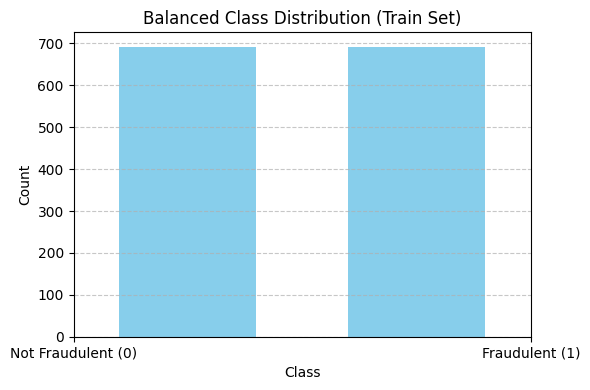

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Print label distribution
print("Balanced training set label counts:", Counter(y_train_balanced))

# Create a histogram
plt.figure(figsize=(6, 4))
plt.hist(y_train_balanced, bins=2, rwidth=0.6, color='skyblue')
plt.xticks([0, 1], ['Not Fraudulent (0)', 'Fraudulent (1)'])
plt.title("Balanced Class Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize balanced training texts
train_encodings = tokenizer(
    X_train_balanced,
    padding='max_length', # ensures same length for all
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Tokenize original unbalanced test texts
test_encodings = tokenizer(
    list(X_test),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Tokenize original unbalanced val texts
val_encodings = tokenizer(
    list(X_val),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Sample index to inspect
sample_idx = 5

# Show token IDs
print("Input IDs:", train_encodings['input_ids'][sample_idx])

# Show attention mask
print("Attention Mask:", train_encodings['attention_mask'][sample_idx])

# Decode tokens back to text for readability
decoded_text = tokenizer.decode(train_encodings['input_ids'][sample_idx], skip_special_tokens=True)
print("Decoded Text:\n", decoded_text)

Input IDs: tensor([  101,  8013,  2326,  5482,  2112,  2051, 21574,  2618,  2595,  6960,
         7300,  3839,  6770,  5420,  6812,  2229,  2968,  2578, 18058,  9525,
         6254,  1998,  4806,  2968,  7300,  2008,  2393,  3316,  2105,  1996,
         2088,  3298,  2449,  2832,  1041, 26989, 23402, 14767,  3623, 15836,
         5547,  5366,  1998,  5335,  8013,  9967,  2005,  2471,  2382,  2086,
         7846,  2031,  2357,  2000,  2149,  2000, 17409,  1998, 23569, 27605,
         4371,  2037,  6960, 22517,  2449,  6194,  2000,  7861, 11452,  5126,
         3623, 15836,  1998, 25845,  3463,  2004,  1037,  9480,  4256,  2057,
        14678,  3579,  2006, 12771,  5851,  2974,  8189, 23242,  6254,  1998,
         4806,  7300,  2008,  5335,  2256,  7846,  2147,  6194, 11598,  2037,
         8013, 10266,  1998,  3298,  3930,  1996,  8013,  2326,  5482,  2097,
         2022,  2241,  1999,  9925, 13109,  1996,  2157,  4018,  2097,  2022,
         2019,  9897,  2112,  1997,  2256, 10904,  21

In [13]:
print(f"Length of encodings: {len(train_encodings['input_ids'])}")
print(f"Length of labels: {len(y_train_balanced)}")

Length of encodings: 1384
Length of labels: 1384


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if isinstance(self.labels, (list, torch.Tensor)):
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

In [15]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTCNNClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2):
        super(BERTCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.dropout = nn.Dropout(0.3)

        # Calculate flattened size after conv and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, 768, 512)  # batch=1, channels=768, seq_len=512
            x = self.relu(self.conv1(dummy_input))
            x = self.pool1(x)
            x = self.relu(self.conv2(x))
            x = self.pool2(x)
            self.flattened_size = x.numel()  # total number of features

        self.fc = nn.Linear(self.flattened_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = torch.flatten(x, start_dim=1)  # flatten except batch dim

        x = self.dropout(x)
        return self.fc(x)




class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=256, num_classes=2, num_layers=1, bidirectional=True):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)


class BERTCNNLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2,
                 cnn_out_channels1=256, cnn_out_channels2=128,
                 lstm_hidden_size=128, num_layers=1, bidirectional=True):
        super(BERTCNNLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        # First conv block
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=cnn_out_channels1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Second conv block
        self.conv2 = nn.Conv1d(in_channels=cnn_out_channels1, out_channels=cnn_out_channels2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(input_size=cnn_out_channels2, hidden_size=lstm_hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(lstm_hidden_size * 2 if bidirectional else lstm_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.permute(0, 2, 1)  # back to (batch, seq_len, channels) for LSTM

        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)



In [16]:
train_dataset = TextDataset(train_encodings, y_train_balanced)
val_dataset = TextDataset(val_encodings, y_val)
test_dataset = TextDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model_with_val_earlystopping(model, train_loader, val_loader, criterion, optimizer, device,
                                       num_epochs=10, patience=3, max_batches_per_epoch=None, plot_losses=True):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_preds_train, all_labels_train = [], []

        for i, batch in enumerate(train_loader):
            if max_batches_per_epoch and i >= max_batches_per_epoch:
                break

            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_preds_train.extend(preds)
            all_labels_train.extend(labels.detach().cpu().numpy())

        avg_train_loss = train_loss / (i + 1)
        train_acc = accuracy_score(all_labels_train, all_preds_train)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds_val, all_labels_val = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds_val.extend(preds)
                all_labels_val.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels_val, all_preds_val)
        val_f1 = f1_score(all_labels_val, all_preds_val, average='macro')
        val_prec = precision_score(all_labels_val, all_preds_val, average='macro')
        val_rec = recall_score(all_labels_val, all_preds_val, average='macro')

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        history.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_acc,
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'val_precision': val_prec,
            'val_recall': val_rec,
            'val_f1': val_f1
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return history


## CNN

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Initialize your model, e.g., BERTCNNClassifier
cnn_model = BERTCNNClassifier(num_classes=2)
cnn_model.to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_cnn = train_model_with_val_earlystopping(
    cnn_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.5620 | Val Loss: 0.6331 | Train Acc: 0.7211 | Val Acc: 0.6205 | Val F1: 0.4731
Epoch 2/10 | Train Loss: 0.3051 | Val Loss: 0.3541 | Train Acc: 0.8793 | Val Acc: 0.8586 | Val F1: 0.6537
Epoch 3/10 | Train Loss: 0.1523 | Val Loss: 0.0811 | Train Acc: 0.9429 | Val Acc: 0.9743 | Val F1: 0.8458
Epoch 4/10 | Train Loss: 0.0858 | Val Loss: 0.0877 | Train Acc: 0.9682 | Val Acc: 0.9670 | Val F1: 0.8265
Epoch 5/10 | Train Loss: 0.0381 | Val Loss: 0.1724 | Train Acc: 0.9863 | Val Acc: 0.9469 | Val F1: 0.7950
Epoch 6/10 | Train Loss: 0.0166 | Val Loss: 0.1151 | Train Acc: 0.9949 | Val Acc: 0.9659 | Val F1: 0.8450
Early stopping at epoch 6


In [19]:
training_cnn = pd.DataFrame(history_cnn)
training_cnn

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.561991,0.721098,0.633105,0.620458,0.551813,0.773262,0.473140
1,2,0.305116,0.879335,0.354100,0.858580,0.620307,0.887502,0.653736
2,3,0.152302,0.942919,0.081080,0.974287,0.889248,0.811979,0.845843
3,4,0.085770,0.968208,0.087668,0.967021,0.818132,0.835427,0.826517
4,5,0.038084,0.986272,0.172430,0.946898,0.734581,0.917558,0.794968
5,6,0.016641,0.994942,0.115106,0.965903,0.799379,0.911186,0.845014


In [20]:
import matplotlib.pyplot as plt

def plot_training_metrics(df):
    # Plot 1: Train vs Validation Loss
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Validation Metrics
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
    plt.plot(df['epoch'], df['val_precision'], label='Precision', marker='o')
    plt.plot(df['epoch'], df['val_recall'], label='Recall', marker='o')
    plt.plot(df['epoch'], df['val_f1'], label='F1 Score', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Train Accuracy vs Validation Accuracy
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


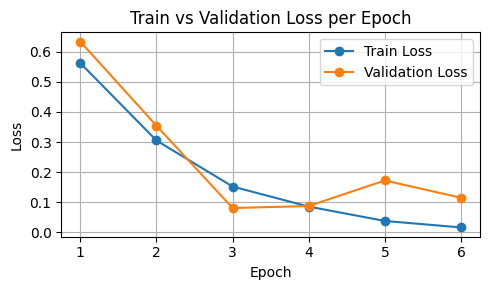

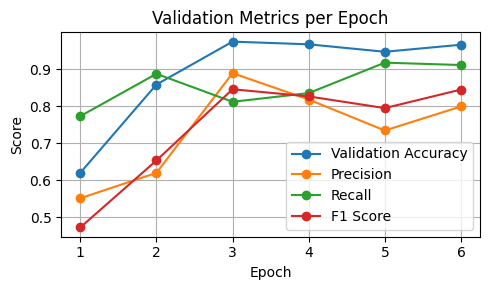

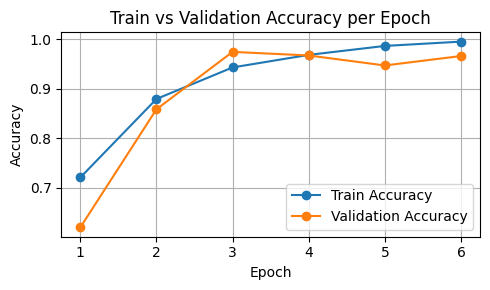

In [21]:
plot_training_metrics(training_cnn)

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_model(model, dataloader, device, class_names=None, print_metrics=True, plot_cm=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    # Create a dataframe with metrics
    metrics_df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1-score': [f1]
    })

    if print_metrics:
        print(f"\nTest Evaluation:")
        print(metrics_df.to_string(index=False))
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"\nClassification Report:\n{report}")

    if plot_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return metrics_df, cm, report




Test Evaluation:
 Accuracy  Precision   Recall  F1-score
  0.96868   0.811531 0.918101  0.855769

Confusion Matrix:
[[1657   44]
 [  12   75]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9928    0.9741    0.9834      1701
         Pos     0.6303    0.8621    0.7282        87

    accuracy                         0.9687      1788
   macro avg     0.8115    0.9181    0.8558      1788
weighted avg     0.9752    0.9687    0.9710      1788



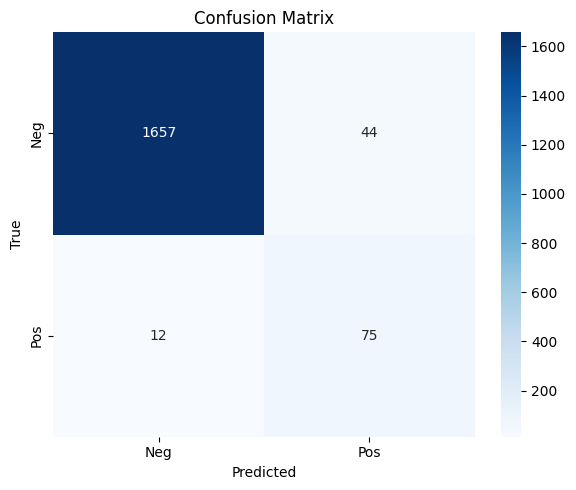

In [23]:
test_cnn, cm_cnn, cf_report_cnn= evaluate_model(cnn_model, test_loader, device, class_names=['Neg', 'Pos'])

In [24]:
print(cf_report_cnn)

              precision    recall  f1-score   support

         Neg     0.9928    0.9741    0.9834      1701
         Pos     0.6303    0.8621    0.7282        87

    accuracy                         0.9687      1788
   macro avg     0.8115    0.9181    0.8558      1788
weighted avg     0.9752    0.9687    0.9710      1788



## LSTM

In [25]:
# Initialize your model, e.g., BERTLSTMClassifier
lstm_model = BERTLSTMClassifier(num_classes=2)
lstm_model.to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_lstm = train_model_with_val_earlystopping(
    lstm_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

Epoch 1/10 | Train Loss: 0.5283 | Val Loss: 0.2202 | Train Acc: 0.7399 | Val Acc: 0.9296 | Val F1: 0.7229
Epoch 2/10 | Train Loss: 0.2689 | Val Loss: 0.5663 | Train Acc: 0.8952 | Val Acc: 0.7630 | Val F1: 0.5709
Epoch 3/10 | Train Loss: 0.1273 | Val Loss: 0.1848 | Train Acc: 0.9588 | Val Acc: 0.9296 | Val F1: 0.7527
Epoch 4/10 | Train Loss: 0.0504 | Val Loss: 0.1509 | Train Acc: 0.9877 | Val Acc: 0.9558 | Val F1: 0.8142
Epoch 5/10 | Train Loss: 0.0298 | Val Loss: 0.1512 | Train Acc: 0.9942 | Val Acc: 0.9547 | Val F1: 0.8063
Epoch 6/10 | Train Loss: 0.0300 | Val Loss: 0.1602 | Train Acc: 0.9928 | Val Acc: 0.9508 | Val F1: 0.8020
Epoch 7/10 | Train Loss: 0.0156 | Val Loss: 0.1021 | Train Acc: 0.9971 | Val Acc: 0.9748 | Val F1: 0.8677
Epoch 8/10 | Train Loss: 0.0194 | Val Loss: 0.0860 | Train Acc: 0.9957 | Val Acc: 0.9827 | Val F1: 0.8955
Epoch 9/10 | Train Loss: 0.0231 | Val Loss: 0.1044 | Train Acc: 0.9949 | Val Acc: 0.9748 | Val F1: 0.8691
Epoch 10/10 | Train Loss: 0.0173 | Val Loss: 0

In [26]:
training_lstm = pd.DataFrame(history_lstm)
training_lstm

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.528261,0.739884,0.220198,0.929570,0.679320,0.810291,0.722907
1,2,0.268894,0.895231,0.566305,0.762996,0.582000,0.859081,0.570894
2,3,0.127301,0.958815,0.184768,0.929570,0.694663,0.897544,0.752660
3,4,0.050366,0.987717,0.150888,0.955841,0.760344,0.905898,0.814204
4,5,0.029780,0.994220,0.151242,0.954723,0.756190,0.888951,0.806314
5,6,0.030003,0.992775,0.160165,0.950811,0.744681,0.908708,0.801952
6,7,0.015638,0.997110,0.102119,0.974846,0.858238,0.877713,0.867682
7,8,0.019351,0.995665,0.086008,0.982672,0.948619,0.854559,0.895472
8,9,0.023090,0.994942,0.104393,0.974846,0.856097,0.883167,0.869067
9,10,0.017318,0.995665,0.222000,0.945780,0.730692,0.906064,0.789084


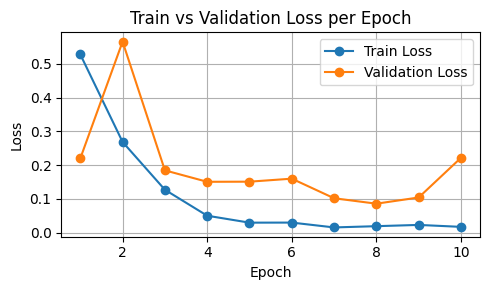

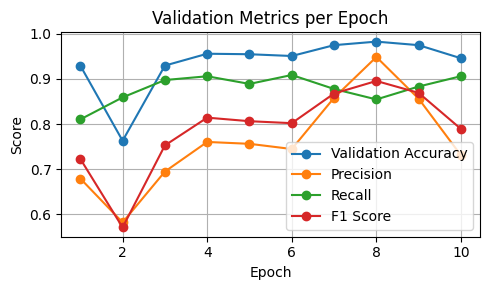

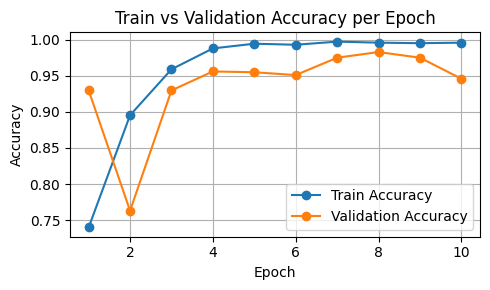

In [27]:
plot_training_metrics(training_lstm)


Test Evaluation:
 Accuracy  Precision   Recall  F1-score
 0.942394   0.727326 0.953364  0.794381

Confusion Matrix:
[[1601  100]
 [   3   84]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9981    0.9412    0.9688      1701
         Pos     0.4565    0.9655    0.6199        87

    accuracy                         0.9424      1788
   macro avg     0.7273    0.9534    0.7944      1788
weighted avg     0.9718    0.9424    0.9519      1788



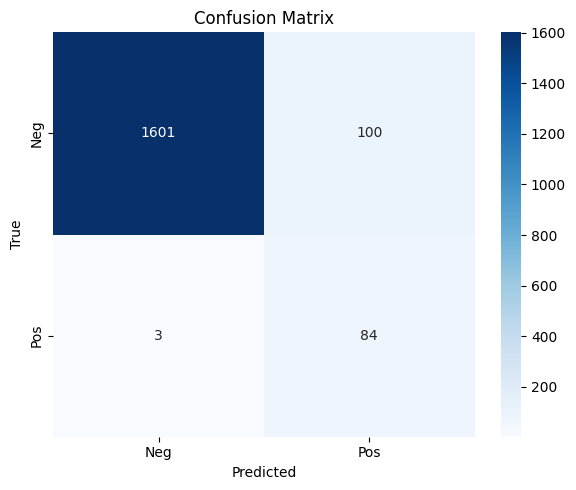

In [28]:
test_lstm, cm_lstm,cf_report_lstm = evaluate_model(lstm_model, test_loader, device, class_names=['Neg', 'Pos'])

In [29]:
print(cf_report_lstm)

              precision    recall  f1-score   support

         Neg     0.9981    0.9412    0.9688      1701
         Pos     0.4565    0.9655    0.6199        87

    accuracy                         0.9424      1788
   macro avg     0.7273    0.9534    0.7944      1788
weighted avg     0.9718    0.9424    0.9519      1788



## CNN-LSTM

In [30]:
# Initialize your model, e.g., BERTCNNLSTMClassifier
cnnlstm_model = BERTCNNLSTMClassifier(num_classes=2)
cnnlstm_model.to(device)

optimizer = torch.optim.Adam(cnnlstm_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_cnnlstm = train_model_with_val_earlystopping(
    cnnlstm_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

Epoch 1/10 | Train Loss: 0.6370 | Val Loss: 0.4984 | Train Acc: 0.6481 | Val Acc: 0.8044 | Val F1: 0.5918
Epoch 2/10 | Train Loss: 0.3651 | Val Loss: 0.2005 | Train Acc: 0.8707 | Val Acc: 0.9530 | Val F1: 0.7913
Epoch 3/10 | Train Loss: 0.2028 | Val Loss: 0.1499 | Train Acc: 0.9364 | Val Acc: 0.9625 | Val F1: 0.8250
Epoch 4/10 | Train Loss: 0.1148 | Val Loss: 0.1722 | Train Acc: 0.9639 | Val Acc: 0.9469 | Val F1: 0.7854
Epoch 5/10 | Train Loss: 0.0766 | Val Loss: 0.2399 | Train Acc: 0.9747 | Val Acc: 0.9318 | Val F1: 0.7711
Epoch 6/10 | Train Loss: 0.0334 | Val Loss: 0.3297 | Train Acc: 0.9928 | Val Acc: 0.9022 | Val F1: 0.7164
Early stopping at epoch 6


In [31]:
training_cnnlstm = pd.DataFrame(history_cnnlstm)
training_cnnlstm

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.636979,0.648121,0.498445,0.804360,0.585307,0.826286,0.591776
1,2,0.365103,0.870665,0.200486,0.953046,0.749287,0.855349,0.791253
2,3,0.202789,0.936416,0.149883,0.962549,0.787425,0.876704,0.825049
3,4,0.114795,0.963873,0.172159,0.946898,0.731786,0.884838,0.785361
4,5,0.076610,0.974711,0.239871,0.931805,0.705951,0.947800,0.771103
5,6,0.033397,0.992775,0.329746,0.902180,0.662083,0.926776,0.716371


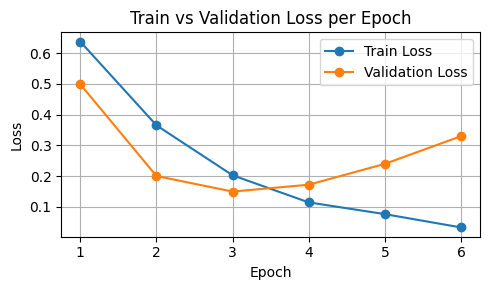

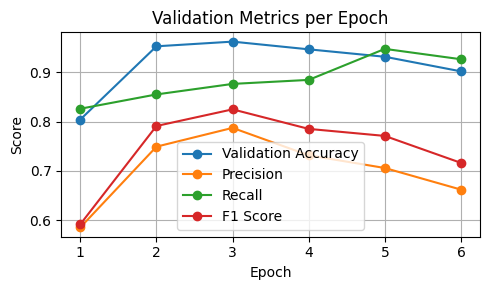

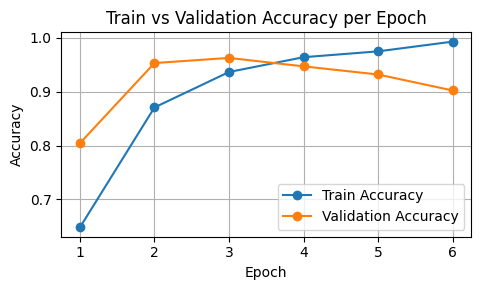

In [32]:
plot_training_metrics(training_cnnlstm)


Test Evaluation:
 Accuracy  Precision   Recall  F1-score
 0.894855   0.656167 0.933832  0.708219

Confusion Matrix:
[[1515  186]
 [   2   85]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9987    0.8907    0.9416      1701
         Pos     0.3137    0.9770    0.4749        87

    accuracy                         0.8949      1788
   macro avg     0.6562    0.9338    0.7082      1788
weighted avg     0.9653    0.8949    0.9189      1788



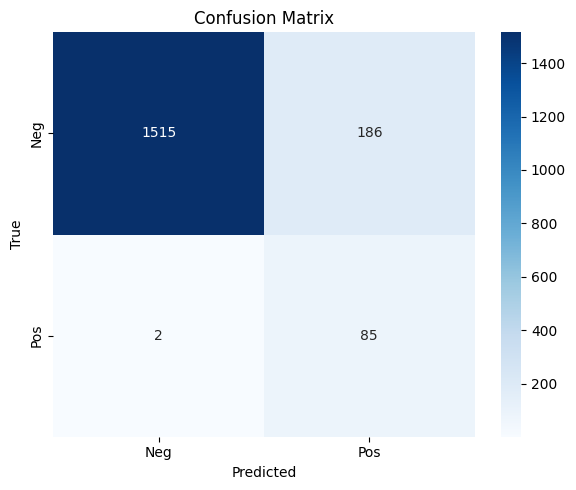

In [33]:
test_cnnlstm, cm_cnnlstm,cf_report_cnnlstm = evaluate_model(cnnlstm_model, test_loader, device, class_names=['Neg', 'Pos'])

In [34]:
print(cf_report_cnnlstm)

              precision    recall  f1-score   support

         Neg     0.9987    0.8907    0.9416      1701
         Pos     0.3137    0.9770    0.4749        87

    accuracy                         0.8949      1788
   macro avg     0.6562    0.9338    0.7082      1788
weighted avg     0.9653    0.8949    0.9189      1788



In [35]:
# Assign model names to each DataFrame
test_cnn['model'] = 'CNN'
test_lstm['model'] = 'LSTM'
test_cnnlstm['model'] = 'CNN-LSTM'

# Concatenate and reset index
stat = pd.concat([test_cnn, test_lstm, test_cnnlstm], axis=0).reset_index(drop=True)
stat

,Accuracy,Precision,Recall,F1-score,model
0,0.968680,0.811531,0.918101,0.855769,CNN
1,0.942394,0.727326,0.953364,0.794381,LSTM
2,0.894855,0.656167,0.933832,0.708219,CNN-LSTM


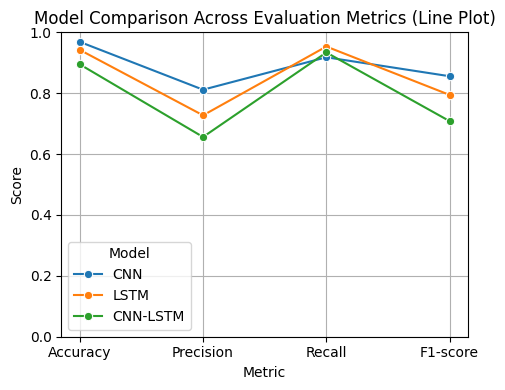

In [36]:
stat_melted = stat.melt(id_vars='model',
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                        var_name='Metric',
                        value_name='Score')

# Plot line chart
plt.figure(figsize=(5, 4))
sns.lineplot(data=stat_melted, x='Metric', y='Score', hue='model', marker='o')
plt.title("Model Comparison Across Evaluation Metrics (Line Plot)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()